# Tutorial 4.2: Postinhibitory Rebound

### Neuroscience goal:
- understand relationship of calcium conductance to bursting behavior and postinhibitory rebound

### Computational goal:
- gain practice writing and using functions
- analyze responses to variations of multiple parameters
- plot functions of 2 parameters

### Overview
- produce model thalamocortical neuron with T-type calcium current
    - assess response to single steps of applied current of variable size and baseline
    - simulate neuron within a function rather than within script
        - different levels of baseline current and step current can be manipulated elsewhere

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def reset_params():
    """reset global parameters and initialize simulation variables"""
    global g_leak, g_na, g_k, g_t, e_na, e_k, e_ca, e_leak, c_membrane
    
    g_leak = 10e-9         # Leak conductance, nS
    g_na = 3.6e-6          # Maximum sodium conductance, uS
    g_k = 1.6e-6           # Maximum potassium conductance, uS
    g_t = 0.22e-6          # Maximum T-type calcium conductance, uS
    e_na = 55e-3           # Sodium reversal potential, mV
    e_k = -90e-3           # Potassium reversal potential, mV
    e_ca = 120e-3          # Calcium reversal potential, mV
    e_leak = -70e-3        # Leak reversal potential, mV
    c_membrane = 100e-12   # Membrane capacitance, pF
    
reset_params()    

In [4]:
dt = 0.01e-3
t = np.arange(0, 0.75, dt)

### note on activation functions and gating variables

- activation functions for sodium and T-type calcium current are not included as dynamical equations because assumed to respond instantaneously to changes in membrane potential: 
    - $m = m_{\infty} = \alpha_m / (\alpha_m + \beta_m)$
    - $m_T = m_{T, \infty}$
    
- in this example, it is the long time constant for inactivation of the calcium current that will produce a slow timescale for burst duration

### a. produce a function that simulates the model neuron described above:
- for a period of 750ms
- function will take two args:
    - baseline current
    - current step
- applied current should be set to the baseline value from 0:250ms, increased by current step from 250:500, and return to baseline from 500:750ms
- function will return:
    - membrane potential as function of time
    - time vector

In [5]:
# set up current with steps
def step_current(baseline, step, t):
    
    current = np.zeros_like(t) + baseline
    third = len(t) // 3
    current[third:(2*third)] = step
    return current
    
i_app = step_current(-200e-12, 100e-12, t)

### b. produce code that loops through a range of values for the baseline current (-200:+200pA) and a range of values for current step (0:+100pA, added to baseline current)
- for each pair of parameters (baseline/current step), calculate total number of spikes produced during current step
    - if two or more spikes produced, calculate minimum ISI
    - plot functions of two variables
        - plot total number of spikes on one graph and minimum ISI on other graph
        - baseline current on x-axis and current step on y-axus


In [6]:
def pir(t, i_app, v_init=-70e-3, t_init=0, h_init=0, n_init=0):
    reset_params()
    # initialize simulation vectors
    v_sim = np.zeros_like(t)
    t_sim = np.zeros_like(t)
    h_sim = np.zeros_like(t)
    n_sim = np.zeros_like(t)

    # gating variable initial conditions
    v_sim[0] = v_init
    t_sim[0] = t_init
    h_sim[0] = h_init
    n_sim[0] = n_init
    
    spikes = np.zeros_like(t)

    # initialize blocking
    blocking = 0
    v_exceeds = 0.0
    v_unblock = -0.06

    # simulate PIR model
    for i in range(1, t.shape[0]):
        if v_sim[i - 1] >= v_exceeds:
            if blocking == 0:
                spikes[i - 1] = 1
                blocking = 1  
        if v_sim[i - 1] < v_unblock:
            blocking = 0       
            
        # update membrane potential (v_sim)
        alpha = ((10**5) * (v_sim[i - 1] + 0.035)) / (1 - np.exp(-100 * (v_sim[i - 1] + 0.035)))
        beta = 4000 * np.exp((-(v_sim[i - 1] + 0.06)) / (0.018))
        m = alpha / (alpha + beta)
        m_t = 1 / (1 + np.exp((-(v_sim[i - 1] + 0.052)) / (0.0074)))
        leak_term = g_leak * (e_leak - v_sim[i - 1])
        na_term = g_na * (m**3) * (h_sim[i - 1]) * (e_na - v_sim[i - 1])
        k_term = g_k * (n_sim[i - 1] ** 4) * (e_k - v_sim[i - 1])
        t_term = g_t * (m_t**2) * (t_sim[i - 1]) * (e_ca - v_sim[i - 1])
        # membrane potential ODE
        dvdt = (leak_term + na_term + k_term + t_term + i_app[i - 1]) / c_membrane
        v_sim[i] = v_sim[i - 1] + (dt*dvdt)
         
        # update h_sim
        alpha = 350 * np.exp(-50 * (v_sim[i - 1] + 0.058))
        beta = 5000 / (1 + np.exp(-100 * (v_sim[i - 1] + 0.028)))
        dhdt = (alpha * (1 - h_sim[i - 1])) - (beta * h_sim[i - 1])
        h_sim[i] = h_sim[i - 1] + (dt*dhdt)

        # update n_sim
        alpha = ((5*(10**4)) * (v_sim[i - 1] + 0.034)) / (1 - np.exp(-100*(v_sim[i - 1] + 0.034)))
        beta = 625 * np.exp(-12.5*(v_sim[i - 1] + 0.044))
        dndt = (alpha * (1 - n_sim[i - 1])) - (beta * n_sim[i - 1])
        n_sim[i] = n_sim[i - 1] + (dt*dndt)

        # update t_sim
        h_t = 1 / (1 + np.exp(500 * (v_sim[i - 1] + 0.076)))        # calcium T-current inactivation variable steady state
        if v_sim[i - 1] < -0.80:
            tau_h = 0.001 * np.exp(15 * (v_sim[i - 1] + 0.467))
        else:
            tau_h = 0.028 + 0.001 * np.exp((-(v_sim[i - 1] + 0.022)) / (0.0105))

        dtdt = (h_t - t_sim[i - 1] / tau_h)
        t_sim[i] = t_sim[i - 1] + (dt*dtdt)

    return v_sim, spikes

In [8]:
numspikes = np.zeros((21,21))
inter_spikes = np.zeros((21,21))
baselines = np.zeros((21,21))
steps = np.zeros((21,21))

for j in range(21):
    for n in range(21):
        baseline = -200e-12 + (n * 20e-12)
        step = (j * 5e-12)
        i_app = step_current(baseline, step, t)
        v_sim, spikes = pir(t, i_app)

        nspikes = np.sum(spikes)
        results = np.where(spikes)[0]
        min_spike_time = 10.0

        for i in range(len(results) - 1):
            if (results[i+1] - results[i]) * dt < min_spike_time:
                min_spike_time = (results[i+1] - results[i]) * dt
        if min_spike_time == 10.0:
            min_spike_time = 0.0
        
        numspikes[21-j-1, n] = nspikes
        inter_spikes[21-j-1, n] = min_spike_time
        baselines[21-j-1, n] = baseline
        steps[21-j-1, n] = step
    

In [42]:
len(steps)

21

In [57]:
# round current and steps for plotting axis ticks
def round_to_sf(arr, n):
    return ["{:.{p}e}".format(x, p=n-1) for x in arr]

to_round_steps = [step[0] for step in steps]

rounded_baselines = round_to_sf(baselines[0], 2)
rounded_steps = round_to_sf(to_round_steps, 1)


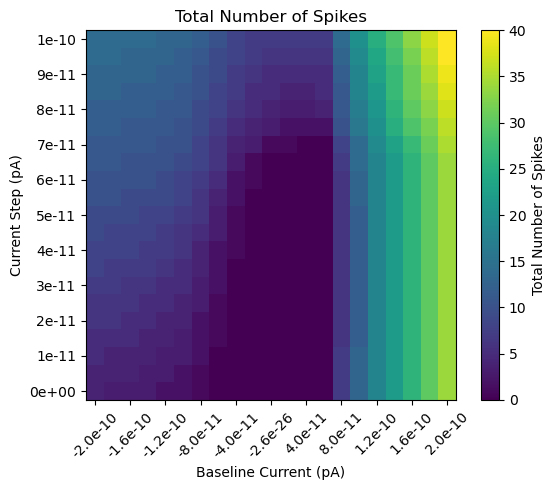

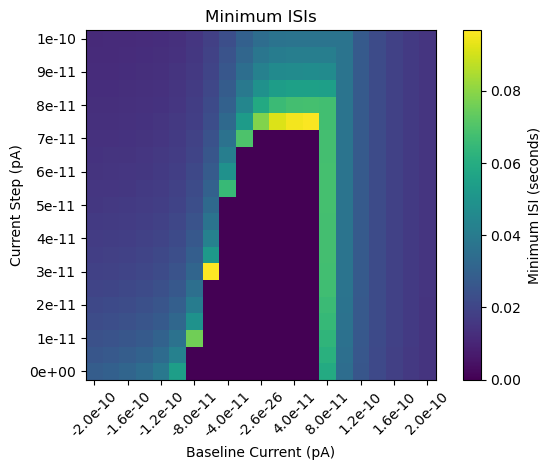

In [58]:
# Plotting the numspikes and interspikes
plt.figure()
plt.imshow(numspikes, cmap='viridis')
plt.colorbar(label='Total Number of Spikes')
plt.xlabel("Baseline Current (pA)")
plt.ylabel("Current Step (pA)")
plt.xticks(np.arange(0, 22, 2), rounded_baselines[::2],
           rotation=45)
plt.yticks(np.arange(0, 22, 2), rounded_steps[::2])
plt.title("Total Number of Spikes")

plt.figure()
plt.imshow(inter_spikes, cmap='viridis')
plt.colorbar(label='Minimum ISI (seconds)')
plt.xlabel("Baseline Current (pA)")
plt.ylabel("Current Step (pA)")
plt.xticks(np.arange(0, 22, 2), rounded_baselines[::2],
           rotation=45)
plt.yticks(np.arange(0, 22, 2), rounded_steps[::2])
plt.title("Minimum ISIs")

plt.tight_layout()


## Plot examples of membrane potentials for each qualitatively distinct type of behavior

In [131]:
def plot_vm(i_app, v_sim, y_bottom=-250e-12):
    """Plot membrane potential under applied current"""
    fig, ax = plt.subplots(2, 1, figsize=(6, 4))

    ax[0].plot(i_app)
    ax[0].set_title('applied current over time')
    ax[0].set_ylabel('$I_{app}$ (pA)')
    ax[0].set_ylim(bottom=y_bottom, top=250e-12)
    
    ax[1].plot(v_sim)
    ax[1].set_ylabel('$V_m$ (V)')
    ax[1].set_title('membrane potential over time')
    ax[1].set_xlabel('time')

    plt.tight_layout()
    plt.show()

### no spiking

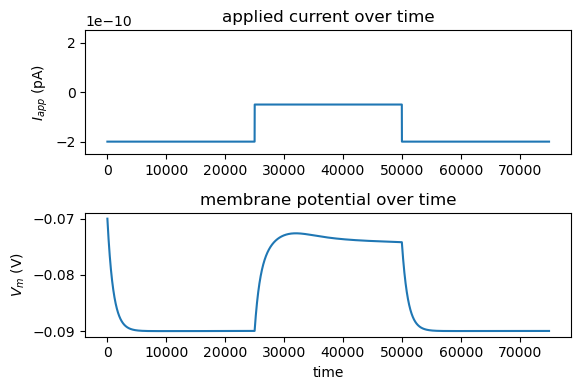

In [132]:
i_app = step_current(-200e-12, -50e-12, t)
v_sim, spikes = pir(t, i_app)
plot_vm(i_app, v_sim)

### spiking with step

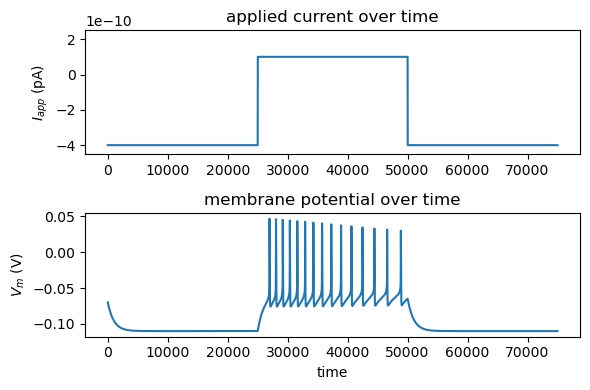

In [133]:
i_app = step_current(-400e-12, 100e-12, t)
v_sim, spikes = pir(t, i_app)
plot_vm(i_app, v_sim, y_bottom=-450e-12)

### spiking with large refractory

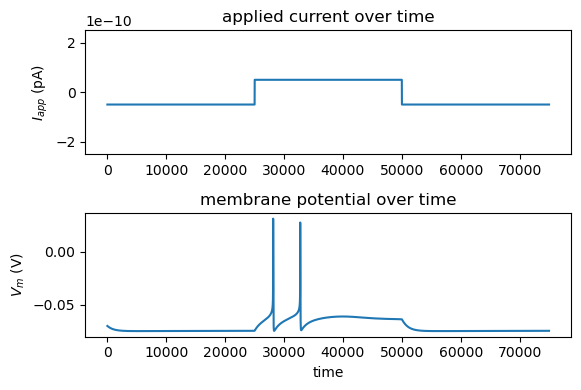

In [134]:
i_app = step_current(-50e-12, 50e-12, t)
v_sim, spikes = pir(t, i_app)
plot_vm(i_app, v_sim)

### firing at baseline increased with current

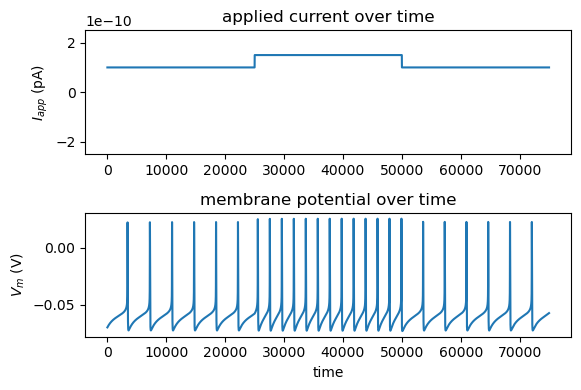

In [135]:
i_app = step_current(100e-12, 150e-12, t)
v_sim, spikes = pir(t, i_app)
plot_vm(i_app, v_sim)